# 0.0. Imports

In [27]:
import requests
import re
import sqlite3

import matplotlib.pyplot as plt
import seaborn           as sns
import pandas            as pd
import numpy             as np

from bs4        import BeautifulSoup
from datetime   import datetime
from sqlalchemy import create_engine

In [41]:
sns.set_style( 'darkgrid' )
sns.set_palette( 'twilight_shifted_r' )

%matplotlib inline 
plt.rcParams['figure.figsize'] = [12,7]

# 1.0. Collect Data

In [68]:
# parameters
headers = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'}

# URL
url = 'https://www2.hm.com/en_us/men/products/jeans.html'

# Request to URL
page = requests.get( url, headers=headers )

# Beautiful soup object
soup = BeautifulSoup( page.text, 'html.parser' )

# ================= product Data ================= 
products = soup.find( 'ul', class_='products-listing small' )
products_list = products.find_all( 'article', class_='hm-product-item' )

#id
product_id = [p.get( 'data-articlecode' ) for p in products_list]

#category
product_cat = [p.get( 'data-category' ) for p in products_list]

# name
product_name = [p.find( 'a', class_='link' ).get_text() for p in products_list]

# price
product_price = [p.find( 'span', class_='price regular' ).get_text() for p in products_list]

# dataframe from the products showed in main page
data = pd.DataFrame( [product_id, product_cat, product_name, product_price] ).T
data.columns = ['product_id', 'product_category', 'product_name','product_price']

In [69]:
data.shape

(36, 4)

## 1.1. Data Collection by Product

In [70]:
custom_header = {'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/74.0.3729.169 Safari/537.36'}
df_compositions = pd.DataFrame()

# unique columns for all products 
aux = []

cols = ['Art. No.', 'Composition', 'Fit', 'Product safety', 'Size']
df_pattern = pd.DataFrame( columns=cols )

# Using just the id from the data to go through each product and catch each feature inside the page of each product
for i in range( len(data) ):

    # Api Requests
    url = 'https://www2.hm.com/en_us/productpage.' + data.loc[i,'product_id'] + '.html'
    
    page = requests.get( url, headers=custom_header )
    
    # Beautifulsoup object
    soup = BeautifulSoup( page.text, 'html.parser' )
    
    # color name and product id
    product_list = soup.find_all( 'a', class_='filter-option miniature' ) + soup.find_all( 'a', class_='filter-option miniature active' )
    
    color_name = [p.get( 'data-color' ) for p in product_list]
    product_id = [p.get( 'data-articlecode' ) for p in product_list]
    
    # color and id data frame
    df_color = pd.DataFrame( [product_id,color_name] ).T
    df_color.columns = ['product_id','color_name']
    
    for j in range(len( df_color )):  
        
        # Api Requests
        url = 'https://www2.hm.com/en_us/productpage.' + df_color.loc[j,'product_id'] + '.html'

        page = requests.get( url, headers=custom_header )

        # Beautifulsoup object
        soup = BeautifulSoup( page.text, 'html.parser' )

        
        # =========== product name ===========
        product_name = soup.find_all( 'h1', class_='primary product-item-headline' )
        product_name = product_name[0].get_text()

        
        # =========== product price ===========
        product_price = soup.find_all( 'div', class_='primary-row product-item-price' )
        product_price = re.findall( r'\d+\.?\d+', product_price[0].get_text() )[0]
        
        # =========== composition ===========
        product_composition_list = soup.find_all( 'div', class_='pdp-description-list-item' )

        composition = [list( filter( None, p.get_text().split( '\n' ) ) ) for p in product_composition_list]

        # rename dataframe
        df_aux = pd.DataFrame( composition ).T
        df_aux.columns = df_aux.iloc[0]
        

        # delete first row
        df_aux = df_aux.iloc[1:].fillna( method='ffill' )

        # remove pocket lining, shell, lining and pocket
        df_aux['Composition'] = df_aux['Composition'].replace( 'Pocket lining: ', '', regex=True )
        df_aux['Composition'] = df_aux['Composition'].replace( 'Shell: ', '', regex=True )
        df_aux['Composition'] = df_aux['Composition'].replace( 'Lining: ', '', regex=True )
        df_aux['Composition'] = df_aux['Composition'].replace( 'Pocket: ', '', regex=True )

        # garantee the same number of columns
        df_aux = pd.concat( [df_pattern, df_aux], axis=0 )
        
        if len(df_aux.columns) > 5:
            df_aux = df_aux.iloc[:,:-1]
        
        # rename columns
        df_aux.columns = ['product_id','composition','fit','product_safety','size']
        
        df_aux['product_name'] = product_name
        df_aux['product_price'] = product_price

        # just to know how many features has in the diferents products
        aux = aux + df_aux.columns.tolist()

        # merge
        df_aux = pd.merge( df_aux, df_color, how='left', on='product_id' )
        
        df_compositions = pd.concat( [df_compositions, df_aux], axis=0 )
        df_compositions = df_compositions.reset_index( drop=True )
        
# Join Showroom data + details
df_compositions['style_id'] = df_compositions['product_id'].apply( lambda x: x[:-3] )
df_compositions['color_id'] = df_compositions['product_id'].apply( lambda x: x[-3:] )

# scrapy datetime
df_compositions['scrapy_datetime'] = datetime.now().strftime( '%Y-%m-%d %H:%M:%S' )

In [5]:
df_compositions.head(2)

,product_id,composition,fit,product_safety,size,product_name,product_price,color_name,style_id,color_id,scrapy_datetime
0,1024256002,"Cotton 99%, Spandex 1%",Slim fit,NaN,NaN,\n\t\t\t\t\t\t\t Slim Jeans,19.99,Light denim blue,1024256,002,2022-01-21 12:32:07
1,1024256002,"Polyester 65%, Cotton 35%",Slim fit,NaN,NaN,\n\t\t\t\t\t\t\t Slim Jeans,19.99,Light denim blue,1024256,002,2022-01-21 12:32:07


# 2.0. Data Cleaning

In [71]:
df_data  = df_compositions.dropna( subset=['product_id'] )

# name
df_data['product_name'] = df_data['product_name'].apply( lambda x: re.search( '\S+.+', x).group() ).str.lower()
df_data['product_name'] = df_data['product_name'].str.replace( ' ', '_' )

# price
df_data['product_price'] = df_data['product_price'].astype( float )

# color_name
df_data['color_name'] = df_data['color_name'].apply( lambda x: x.replace(' ','_').lower() if pd.notnull(x) else x )

# fit 
df_data['fit'] = df_data['fit'].apply( lambda x: x.replace(' ','_').lower() if pd.notnull(x) else x )

# size numeber
df_data['size_number'] = df_data['size'].apply( lambda x: re.search( '\d{3}cm', x ).group() if pd.notnull(x) else x )
df_data['size_number'] = df_data['size_number'].apply( lambda x: str( x ).replace( 'cm', '') )

# size_model
df_data['size_model'] = df_data['size'].str.extract( '(\d+/\d+)' )

# product safety dropped
df_data.drop( 'product_safety', axis=1, inplace=True )

# ============== composition ===============

df = df_data['composition'].str.split( ',', expand=True ).reset_index( drop=True )

df_ref = pd.DataFrame( columns=['cotton','polyester','elasterell','spandex'], index=np.arange( len(data ) ) )

# ============== composition ===============

# ===== cotton =====
df_cotton_0 = df.loc[df[0].str.contains( 'Cotton', na=True ), 0]

df_cotton_1 = df.loc[df[1].str.contains( 'Cotton', na=True ), 1]

# combine
df_cotton = df_cotton_0.combine_first( df_cotton_1 )
df_cotton.name = 'cotton'

df_ref = pd.concat( [df_ref, df_cotton], axis=1 )
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated( keep='last' )]

# ===== polyester =====  
df_polyester_0 = df.loc[df[0].str.contains( 'Polyester', na=True ), 0]

df_polyester_1 = df.loc[df[1].str.contains( 'Polyester', na=True ), 1]

# combine
df_polyester = df_polyester_0.combine_first( df_polyester_1 )
df_polyester.name = 'polyester'

df_ref = pd.concat( [df_ref, df_polyester], axis=1 )
df_ref = df_ref.iloc[:, ~df_ref.columns.duplicated( keep='last')]

# ===== elasterell =====
df_elasterell = df.loc[df[1].str.contains( 'Elasterell', na=True ), 1]
df_elasterell.name = 'elasterell'

df_ref = pd.concat( [df_ref, df_elasterell], axis=1 )
df_ref = df_ref.loc[:, ~df_ref.columns.duplicated( keep='last' ) ]

# ===== spandex =====
df_spandex_1 = df.loc[df[1].str.contains( 'Spandex', na=True ), 1]

df_spandex_2 = df.loc[df[2].str.contains( 'Spandex', na=True ), 2]

df_spandex_3 = df.loc[df[3].str.contains( 'Spandex', na=True ), 3]

aux = df_spandex_1.combine_first( df_spandex_2 )
df_spandex = aux.combine_first( df_spandex_3 )
df_spandex.name = 'spandex'
                                                 
df_ref = pd.concat( [df_ref, df_spandex], axis=1 )
df_ref = df_ref.loc[:, ~df_ref.columns.duplicated( keep='last' )]

# join of combine with product_id
df_aux_ = pd.concat( [df_data['product_id'].reset_index( drop=True ), df_ref], axis=1 )

df_aux_['cotton']     = df_aux_['cotton'].apply( lambda x: int( re.search( '\d+',x ).group() ) / 100 if pd.notnull( x ) else x )
df_aux_['polyester']  = df_aux_['polyester'].apply( lambda x: int( re.search( '\d+',x ).group() ) / 100 if pd.notnull( x ) else x )
df_aux_['elasterell'] = df_aux_['elasterell'].apply( lambda x: int( re.search( '\d+',x ).group() ) / 100 if pd.notnull( x ) else x )
df_aux_['spandex']    = df_aux_['spandex'].apply( lambda x: int( re.search( '\d+',x ).group() ) / 100 if pd.notnull( x ) else x )

# final join
df_aux_ = df_aux_.groupby( 'product_id' ).max().reset_index().fillna(0)

df_data = pd.merge( df_data,df_aux_, on='product_id', how='left' )

# drop columns
df_data = df_data.drop( columns=['size', 'composition'], axis=1 )

# drop duplicatates
df_data = df_data.drop_duplicates()

In [7]:
df_data.head()

,product_id,fit,product_name,product_price,color_name,style_id,color_id,scrapy_datetime,size_number,size_model,cotton,polyester,elasterell,spandex
0,1024256002,slim_fit,slim_jeans,19.99,light_denim_blue,1024256,002,2022-01-21 12:32:07,nan,NaN,0.99,0.65,0.0,0.01
2,1024256003,slim_fit,slim_jeans,19.99,light_denim_blue,1024256,003,2022-01-21 12:32:07,189,31/32,0.99,0.65,0.0,0.01
4,1024256004,slim_fit,slim_jeans,19.99,denim_blue,1024256,004,2022-01-21 12:32:07,nan,NaN,0.99,0.65,0.0,0.01
6,1024256005,slim_fit,slim_jeans,19.99,dark_blue,1024256,005,2022-01-21 12:32:07,nan,NaN,0.99,0.65,0.0,0.01
8,1024256006,slim_fit,slim_jeans,19.99,dark_denim_blue,1024256,006,2022-01-21 12:32:07,188,31/32,1.00,0.00,0.0,0.01


# 3.0. Data Insert

In [72]:
data_insert = df_data[[
    'product_id',
    'style_id',
    'color_id',
    'product_name',
    'color_name',
    'fit',
    'product_price',
    'size_number',
    'size_model',
    'cotton',
    'polyester',
    'elasterell',
    'spandex',
    'scrapy_datetime'
]]

In [50]:
# query = """
#     CREATE TABLE vitrine(
    
#     product_id         TEXT,
#     style_id           TEXT,
#     color_id           TEXT,
#     product_name       TEXT,
#     color_name         TEXT,
#     fit                TEXT,
#     product_price      REAL,
#     size_number        TEXT,
#     size_model         TEXT,
#     cotton             REAL,
#     polyester          REAL,
#     elasterell         REAL,
#     spandex            REAL,
#     scrapy_datetime    TEXT
#     )
# """

In [48]:
# query_drop = """
#     DROP TABLE vitrine
# """

In [51]:
# create table
conn = sqlite3.connect( 'database_hm.sqlite' )
# cursor = conn.execute( query_drop )
cursor = conn.execute( query )
conn.commit()

In [73]:
# create database connection
conn = create_engine( 'sqlite:///database_hm.sqlite', echo=False )

# data insert
data_insert.to_sql( 'vitrine', con=conn, if_exists='append', index=False )

In [74]:
query = """
    SELECT * FROM vitrine
"""

pd.read_sql_query( query, conn ).head()

,product_id,style_id,color_id,product_name,color_name,fit,product_price,size_number,size_model,cotton,polyester,elasterell,spandex,scrapy_datetime
0,1024256002,1024256,002,slim_jeans,light_denim_blue,slim_fit,19.99,nan,None,0.99,0.65,0.0,0.01,2022-01-21 12:32:07
1,1024256003,1024256,003,slim_jeans,light_denim_blue,slim_fit,19.99,189,31/32,0.99,0.65,0.0,0.01,2022-01-21 12:32:07
2,1024256004,1024256,004,slim_jeans,denim_blue,slim_fit,19.99,nan,None,0.99,0.65,0.0,0.01,2022-01-21 12:32:07
3,1024256005,1024256,005,slim_jeans,dark_blue,slim_fit,19.99,nan,None,0.99,0.65,0.0,0.01,2022-01-21 12:32:07
4,1024256006,1024256,006,slim_jeans,dark_denim_blue,slim_fit,19.99,188,31/32,1.00,0.00,0.0,0.01,2022-01-21 12:32:07


# 4.0. Data Description

In [2]:
conn = create_engine( 'sqlite:///database_hm.sqlite', echo=False )

query = """
    SELECT * FROM vitrine
"""

df_raw = pd.read_sql_query( query, con=conn )

In [4]:
df01 = df_raw.copy()

In [5]:
df01.head()

,product_id,style_id,color_id,product_name,color_name,fit,product_price,size_number,size_model,cotton,polyester,elasterell,spandex,scrapy_datetime
0,1024256002,1024256,002,slim_jeans,light_denim_blue,slim_fit,19.99,nan,None,0.99,0.65,0.0,0.01,2022-01-21 12:32:07
1,1024256003,1024256,003,slim_jeans,light_denim_blue,slim_fit,19.99,189,31/32,0.99,0.65,0.0,0.01,2022-01-21 12:32:07
2,1024256004,1024256,004,slim_jeans,denim_blue,slim_fit,19.99,nan,None,0.99,0.65,0.0,0.01,2022-01-21 12:32:07
3,1024256005,1024256,005,slim_jeans,dark_blue,slim_fit,19.99,nan,None,0.99,0.65,0.0,0.01,2022-01-21 12:32:07
4,1024256006,1024256,006,slim_jeans,dark_denim_blue,slim_fit,19.99,188,31/32,1.00,0.00,0.0,0.01,2022-01-21 12:32:07


## 4.1. Data Dimension

In [6]:
print(f' Number of Rows:    {df01.shape[0]}' )
print(f' Number of Columns: {df01.shape[1]}' )

 Number of Rows:    408
 Number of Columns: 14


## 4.2. Data Types

In [7]:
df01.dtypes

product_id          object
style_id            object
color_id            object
product_name        object
color_name          object
fit                 object
product_price      float64
size_number         object
size_model          object
cotton             float64
polyester          float64
elasterell         float64
spandex            float64
scrapy_datetime     object
dtype: object

In [8]:
# convert object to datetime
df01['scrapy_datetime'] = pd.to_datetime( df01['scrapy_datetime'] )

## 4.3. Missing Values

In [64]:
df01.isnull().sum()

product_id           0
style_id             0
color_id             0
product_name         0
color_name           0
fit                  0
product_price        0
size_number          0
size_model         189
cotton               0
polyester            0
elasterell           0
spandex              0
scrapy_datetime      0
dtype: int64

In [9]:
df01.isnull().sum() / len( df01 )

product_id         0.000000
style_id           0.000000
color_id           0.000000
product_name       0.000000
color_name         0.000000
fit                0.000000
product_price      0.000000
size_number        0.000000
size_model         0.639706
cotton             0.000000
polyester          0.000000
elasterell         0.000000
spandex            0.000000
scrapy_datetime    0.000000
dtype: float64

## 4.4. Fill Missing Values

Estratégia foi preencher com os valores com maior quantidade na colunas "size_model" e como a maior quantidade foi 31/32 e 32/32, vamos adotar que as outras peças adotam esse size_number de 31/32

In [66]:
count = df01['size_model'].value_counts()
count.name = 'values'

aux = pd.DataFrame( count ).reset_index()
aux

,index,values
0,31/32,60
1,32/32,33
2,31/30,9
3,33/32,6
4,32/30,3


In [67]:
df01['size_model'].fillna( aux['index'][0], inplace=True )

## 4.1.5. Description

In [11]:
num_attributes = df01.select_dtypes( include=['float64'] )
cat_attributes = df01.select_dtypes( include=['object'] )

### 4.1.5.1 Numeric Data

In [98]:
def numeric_statistics( df ):
    
    dic = {
        "type": df.dtypes.values,
        "Null": df.shape[0] - df.count().values,
        "Null%": 100 * (df.shape[0] - df.count().values)/df.shape[0],
        "Mean": df.mean(),
        "Median": df.median(),
        "Std": df.std(),
        "Std%": df.std() / df.mean(),
        "Min": df.min(),
        "Max": df.max(),
        "Range": df.max() - df.min(),
        "Skew": df.skew(),
        "Kurtosis": df.kurtosis()
    }
    
    return pd.DataFrame( dic, index=df.columns )

In [99]:
numeric_statistics( num_attributes )

,type,Null,Null%,Mean,Median,Std,Std%,Min,Max,Range,Skew,Kurtosis
product_price,float64,0,0.0,28.708137,24.99,10.651803,0.371038,7.99,59.99,52.00,0.557244,0.283577
cotton,float64,0,0.0,0.966642,0.99,0.061391,0.063509,0.72,1.00,0.28,-2.503719,5.389037
polyester,float64,0,0.0,0.288358,0.06,0.331222,1.148650,0.00,1.00,1.00,0.563432,-1.314408
elasterell,float64,0,0.0,0.002451,0.00,0.014120,5.761089,0.00,0.09,0.09,5.621052,29.866449
spandex,float64,0,0.0,0.011667,0.01,0.006361,0.545204,0.00,0.02,0.02,-0.155644,-0.599347


Comparando duas colunas numéricas podemos entender oque algumas medidas apresentam.

1. **Mean**
    - podemos ver que a média para o **product_price** pode representar melhor esta variável. Pois como a variável está mais concentrada a média não é tão afetada por valores extremos como é na coluna **elasterell**. Onde apresenta um valor para a média que talvez nem exista pontos com esse valor, pois foi bastante afetado por valores extremos.


2. **Std**
    - Em termos absoluto difícil dizer qual variável tem uma maior variação, mas utilizando o Coeficiente de variação(Std%) podemos ver que a variável **elasterell** variou bem mais que a **product_price** em termos percentuais.


3. **Skew**
    - Podemos ver também que com os valores de skew temos uma ideia de como está a assimetria da distribuição em relação a distribuição normal. Para a variável **elasterell** é difícil enxergar o mínimo de assimetria que existe pois não possui uma distribuição tão igualitária. Já para a variável **product_price**, podemos ver que existe de fato uma certa assimetria a direita que é ratificada pelo valor mais positivo de skew.


4. **Kurtosis**
    - Podemos ver que esse valor revela o quão carregada estão as caudas da distribuição. Ficando claro que as caudas da variável **elasterell** são bem mais carregadas que do **product_price** que é mais bem distribuída.

In [93]:
numeric_statistics( num_attributes ).loc[['product_price','elasterell'],:]

,type,Null,Null%,Mean,Median,Std,Std%,Min,Max,Range,Skew,Kurtosis
product_price,float64,0,0.0,28.708137,24.99,10.651803,0.371038,7.99,59.99,52.00,0.557244,0.283577
elasterell,float64,0,0.0,0.002451,0.00,0.014120,5.761089,0.00,0.09,0.09,5.621052,29.866449


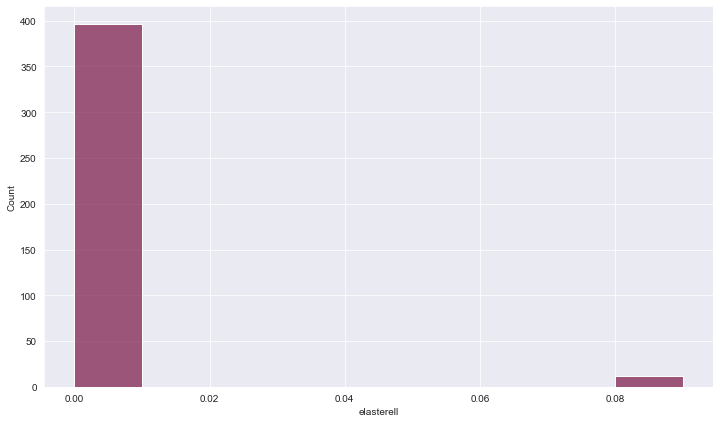

In [87]:
sns.histplot( num_attributes['elasterell'], bins=9 );


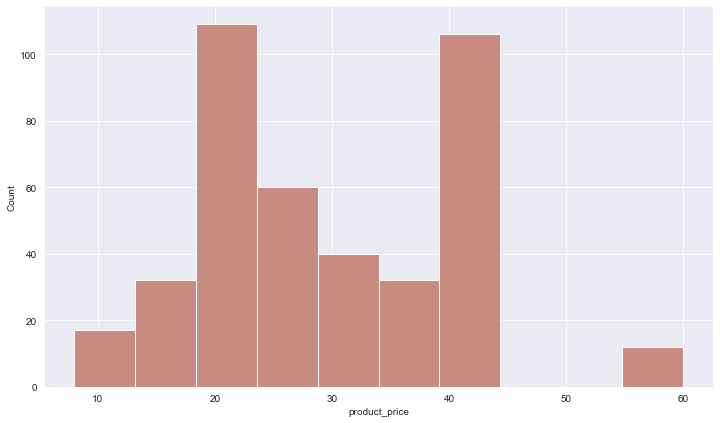

In [45]:
sns.histplot( num_attributes['product_price'], 
             color=sns.color_palette('twilight_shifted_r')[1]);

### 4.1.5.1 Category Data

## 4.2. Feature Engineering

## 4.3. Filter Data